In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


2024-11-26 11:27:15.463950: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Axes: >

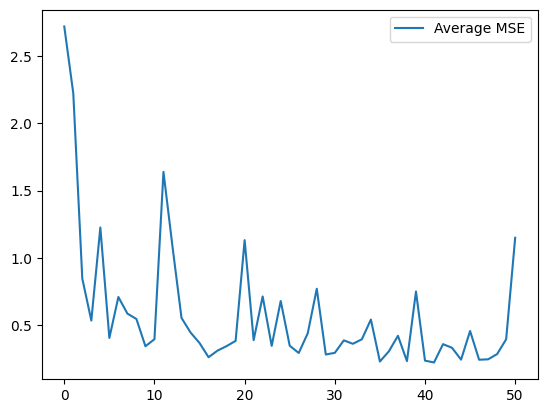

In [2]:
# Plotting the MSE from the dev set versus the number of Epochs 

mse_first = pd.read_csv('AverageMSEFromTraining.csv')
mse_last = pd.read_csv('AverageMSEFromTraining_from30.csv')

combined_mse_dev = pd.concat([mse_first, mse_last]).reset_index(drop = True)
combined_mse_dev.plot()

### Using the model trained on 40 epochs based on the training curve above 

Model parameters:  
time step = 50   
layers = 5   
nodes = 100    
dropout rate = 0.3   



In [3]:
model = load_model('lstm_40_epochs.keras')
all_merged_data = pd.read_csv('all_merged_data.csv')

In [4]:
# DATA PREP

sample_size = int(all_merged_data.shape[1] * 0.1)  # Calculate 10% of the columns

# Randomly select 10% of the columns
sampled_columns = all_merged_data.sample(n=sample_size, axis=1, random_state=42)  # Use random_state for reproducibility

# Separate the sampled columns as test columns and the rest as train columns
train = all_merged_data.drop(columns=sampled_columns.columns)  # Remaining 90% of columns
test = sampled_columns  # 10% of randomly selected columns
test['date'] = all_merged_data['date']  # Add 'date' back to test
train['date'] = all_merged_data['date']  # Add 'date' back to train

sample_size_dev = int(train.shape[1] * 0.1)  # Calculate 10% of the columns
# Randomly select 10% of the columns
sampled_columns_dev = train.sample(n=sample_size_dev, axis=1, random_state=42)  # Use random_state for reproducibility

# Separate the sampled columns as dev columns and the rest as true train columns
train = train.drop(columns=sampled_columns_dev.columns)  # Remaining 90% of columns
dev = sampled_columns_dev  # 10% of randomly selected columns

time_step = 50 # Define time step (number of previous observations

In [5]:
# Cleaning up some data leakage 
columns_to_drop = ['Dumbbells_y', 'Headlamps_y', 'Hoop earrings_x', 'Baby carriers_x', 'Signet rings_y', 
 'Graphic novels_y', 'Baby detergent_x', 'Camping tents_y', 'Baby rattles_y', 
 'Organic spices_x', 'Hiking boots_x', 'Water filters_y'] 

test = test.drop(columns = columns_to_drop) 

In [6]:
# import test results (MSE per keyword) - this aligns one to one with test.columns for keywords
mse_keyword_test = pd.read_csv('mse_per_keyword_test.csv').drop(columns = 'Unnamed: 0')

In [7]:
# Find the index of the minimum/maximum number
min_index = mse_keyword_test.idxmin()
max_index = mse_keyword_test.idxmax()

print('Keyword with highest accuracy:' , test.columns[min_index['MSE']])
print('Keyword with lowest accuracy:' , test.columns[max_index['MSE']])

Keyword with highest accuracy: Dashboard cover
Keyword with lowest accuracy: Maps


In [8]:
# Find the median of the 'Age' column
median = mse_keyword_test['MSE'].median()

index_of_median = (mse_keyword_test['MSE'] - median).abs().idxmin()

print('Keyword with median MSE performance:', test.columns[index_of_median])

Keyword with median MSE performance: Keyboards


In [9]:
# SETUP VARIABLES FOR PREDICTION
df_pred = test
keyword_to_predict = 'Keyboards'
time_step = 50 # this needs to mirror what is in training 

In [10]:
def predict_future(model, keyword_data, time_step, num_predictions):
    # Get the last known data for the keyword
    last_sequence = keyword_data[-time_step:]  # The last time-step sequence from the data
    predictions = []

    for _ in range(num_predictions):
        # Reshape to match the input shape for the RNN
        predicted = model.predict(last_sequence.reshape(1, time_step, 1))
        predictions.append(predicted[0, 0])  # Get the predicted value

        # Update the sequence with the predicted data for the next step
        last_sequence = np.append(last_sequence[1:], predicted)  # Update the last sequence

    return predictions

# Example usage:
keyword_column_index = df_pred.columns.get_loc(keyword_to_predict)  # Get the column index for the keyword
keyword_data = df_pred[keyword_to_predict].values  # Extract the data for the keyword
future_predictions = predict_future(model, keyword_data, time_step, num_predictions=10)

print(f"Future predictions for {keyword_to_predict}: {future_predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Future predictions for Keyboards: [0.5028388, 0.50334585, 0.50361663, 0.51339495, 0.51531494, 0.5162925, 0.51682013, 0.51505554, 0.5200171, 0.5145356]


In [11]:
def predict_full_series(model, keyword_data, time_step, future_steps=10):
    predictions = []
    
    # Part 1: Predict across the full existing series
    for i in range(len(keyword_data) - time_step):
        # Get the current sequence
        current_sequence = keyword_data[i:i + time_step]
        
        # Predict the next value based on the current sequence
        predicted = model.predict(current_sequence.reshape(1, time_step, 1))
        predictions.append(predicted[0, 0])  # Append the predicted value

    return predictions

# Example usage:
keyword_column_index = df_pred.columns.get_loc(keyword_to_predict)  # Get the column index for the keyword
keyword_data = df_pred[keyword_to_predict].values  # Extract the data for the keyword
full_series_predictions = predict_full_series(model, keyword_data, time_step, future_steps=50)

#print(f"Full series predictions for {keyword_to_predict}: {full_series_predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━

In [12]:
#### Establish the correct dates and DF for prediction #####


# ensure 'date' is in datetime format
df_pred['date'] = pd.to_datetime(all_merged_data['date'])

# Adjust the date range for full series predictions to account for time_step
adjusted_dates = df_pred['date'][time_step:].reset_index(drop=True)
full_series_predictions_df = pd.DataFrame({
    'date': adjusted_dates,
    keyword_to_predict: full_series_predictions
})


# Generate new dates for future predictions, starting after the last date
last_date = adjusted_dates.iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=len(future_predictions), freq='7D')
future_predictions_df = pd.DataFrame({
    'date': future_dates,
    keyword_to_predict: future_predictions
})

# Combine the full series and future predictions into one DataFrame
combined_df = pd.concat([full_series_predictions_df, future_predictions_df], ignore_index=True)


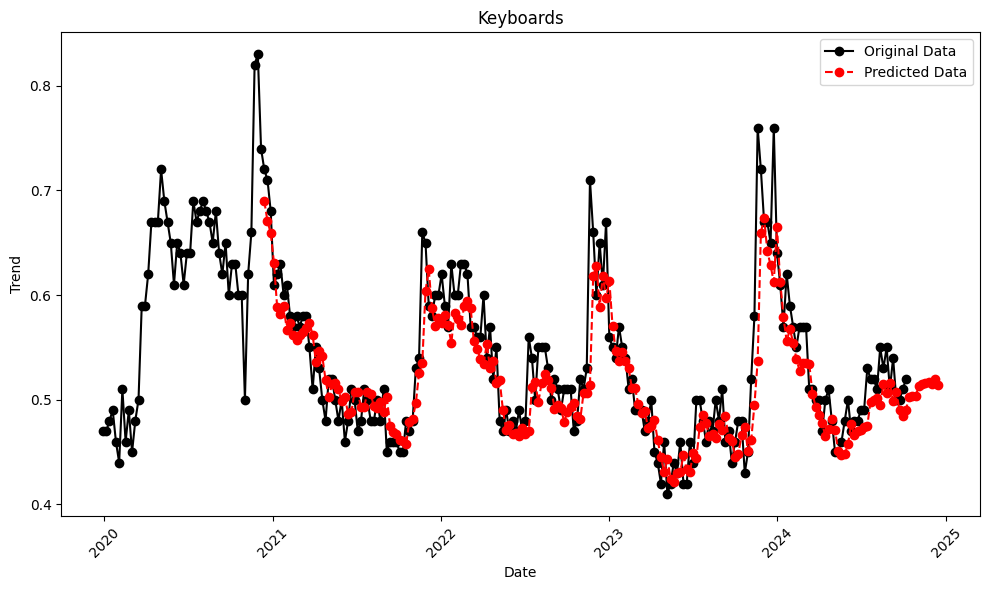

In [13]:
# Set the figure size (width, height) before plotting
plt.figure(figsize=(10, 6))

# Plot original data
plt.plot(test['date'], df_pred[keyword_to_predict], marker='o', linestyle='-', color='black', label='Original Data')

# Plot predicted data
plt.plot(combined_df['date'], combined_df[keyword_to_predict], marker='o', linestyle='--', color='red', label='Predicted Data')

# Customize plot
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title(keyword_to_predict)
plt.xticks(rotation=45)
plt.tight_layout()

# Add legend to differentiate the two lines
plt.legend()

# Show plot
plt.show()

### Model evaluation on all test data 

In [ ]:
time_step = 50 
mse_keyword = [] 
for keyword_to_predict in test.columns: 

    keyword_column_index = test.columns.get_loc(keyword_to_predict)  # Get the column index for the keyword
    keyword_data = test[keyword_to_predict].values  # Extract the data for the keyword
    
    # Get the predictions from the model
    full_series_predictions = predict_full_series(model, keyword_data, time_step, future_steps=0) # predict no future steps for MSE calculation 
    
    # Get the true values (the actual data you want to compare the predictions against)
    true_values = keyword_data[time_step:]  # Start from the 'time_step' index onward
    
    # Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(true_values[:len(full_series_predictions)], full_series_predictions)
    mse_keyword.append(mse) 




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━

In [50]:
mse_keyword_test = pd.DataFrame(mse_keyword, columns = ['MSE'])
mse_keyword_test.to_csv('mse_per_keyword_test.csv')